# DeepDiTau Jet Tagging

This notebook will discuss tagging particle flow jets as originating from boosted ditaus.
The physics motivation of this tagging is in the context of the search for $h \to aa \to \mu\mu\tau\tau$.
If the mass difference between the Higgs scalar $h$ and the pseudoscalar $a$ is sufficient, the two decay products will have small separation.
In the case of two $\tau$ candidates, the overlapping decay products will cause the standard CMS Hadron Plus Strip (HPS) algorithm to fail to identify the $\tau$ leptons.

## Overview

Jets are reconstructed using [CMSSW](https://github.com/cms-sw/cmssw/).
At its core, a jet is a cluster of particles selected via a distance metric.
The most common approach used in CMS is to reconstruct jets with the [anti-$k_{t}$ algorithm](https://arxiv.org/abs/0802.1189).
The jets used in this study are anti-$k_{t}$ jets with distance parameter $R=0.4$ (AK4). Alternative approaches can use a larger distance parameter (AK8) or an alternative jet clustering algorithm Cambridge-Aachen (CA8).

Jets are most commonly produced from either gluons or quarks with quarks of different flavors typically having different properties (light jets arising from $u$, $d$, or $s$ quarks, and heavy jets arising from $c$ or $b$ quarks). Additionally, $\tau$ leptons, when they decay hadronically, will produce a jet signature.

The dataformat most commonly used in high energy physics (HEP) is the [ROOT](https://root.cern.ch/) TTree.
For this study, a simple module to dump the CMS representation of a jet into a TTree can be found [here](https://github.com/dntaylor/DevTools-Ntuplizer/blob/106X/src/DeepJetTree.cc).

The remainder of this notebook will discuss converting this HEP-based dataformat into a representation useable by standard python-based machine learning tools.

## Conversion

This section will discuss the conversion step implemented in [convert.py](convert.py).
The conversion step reads in ROOT TTrees using [uproot](https://github.com/scikit-hep/uproot) and outputs [numpy](https://github.com/numpy/numpy) arrays in a format that is easily readable for the training step. As an intermediate step, `JaggedArray`s from the [awkward](https://github.com/scikit-hep/awkward-array) package are used. These are modified `numpy` arrays with an additional array of `offsets` that add an additional jagged dimension to the array. This is a common data structure within HEP analysis. Any number of particles can be reconstructed in a given event. This jagged structure is not well supported by many machine learning tools which typically expect fixed array structures. There are many approaches to handling this feature, some of which will be discussed here.

In [1]:
import os
import random
import numpy as np
import uproot
import awkward

For this study, we will use two types of Monte Carlo (MC) simulation physics process samples.
The first is $t\bar{t}$ production which will produce a mix of $b$-jets and light quark jets.
The second is a signal sample which will produce our boosted $\tau\tau$ signatures.
In the full analysis, a third sample is used which includes only QCD production and primarily produces light quark jets.

In [2]:
inDir = '../crab_2020-01-23_DeepJetTree_94X_v2'
fnames = []
for r, d, f in os.walk(inDir):
    for fname in f:
        if fname.endswith('.root'):
            fnames += [os.path.join(r,fname)]
random.shuffle(fnames)
sigfname = next(f for f in fnames if 'SUSY' in f)
ttfname = next(f for f in fnames if 'TTJets' in f)

Let's look at the tree structure.

In [3]:
treename = 'deepJetTree/DeepJetTree'
tree = uproot.open(sigfname)[treename]
tree.show()

num_vertices               (no streamer)              asdtype('>i4')
jet_pt                     (no streamer)              asdtype('>f4')
jet_eta                    (no streamer)              asdtype('>f4')
jet_phi                    (no streamer)              asdtype('>f4')
jet_energy                 (no streamer)              asdtype('>f4')
jet_mass                   (no streamer)              asdtype('>f4')
jet_jetCharge              (no streamer)              asdtype('>f4')
jet_chargedMultiplicity    (no streamer)              asdtype('>f4')
jet_neutralMultiplicity    (no streamer)              asdtype('>f4')
jet_chargedHadronMultiplicity
                           (no streamer)              asdtype('>f4')
jet_neutralHadronMultiplicity
                           (no streamer)              asdtype('>f4')
jet_muonMultiplicity       (no streamer)              asdtype('>f4')
jet_electronMultiplicity   (no streamer)              asdtype('>f4')
jet_photonMultiplicity     (no streamer)   

The structures you see correspond to two types of arrays:
 - `asdtype('>f4')`: which is a single flat array and corresponds to jet features
 - `asjagged(asdtype('>f4'), 10)`: which is a `JaggedArray` and corresponds to the jet daughter features

The tree is built such that each row in the tree corresponds to a jet.
This is different than a standard HEP tree where each row is an event.
The reason for this choice is because reading a singly-jagged array from a ROOT TTree is very efficient.

### Truth definition

We will first define the truth categories that we want to predict.

In [4]:
# must create these branches, they are what is output
out_truth = ['lightjet', 'bjet', 'TauHTauH']

# here make a map for convenience later
truth_map = {
    'lightjet': ['jet_isUD','jet_isS','jet_isG','jet_isC'],
    'bjet': ['jet_isB'],
    'TauHTauH': ['jet_isTauHTauH'],
}

truth_branches = []
for ot, bs in truth_map.items():
    truth_branches += bs

def build_truth(arrays,fname=''):
    keep = np.zeros_like(arrays['jet_pt'], dtype=bool)
    for t, bs in truth_map.items():
        thistruth = np.zeros_like(keep, dtype=bool)
        for b in bs:
            # only grab a certain type of jet from each sample
            if 'SUSY' in fname and 'Tau' not in t: continue
            if 'TTJet' in fname and t not in ['bjet','lightjet']: continue
            if 'QCD' in fname and t not in ['bjet','lightjet']: continue
            if t=='lightjet': # toss 90% of lightjet since we have so much
                rdf = np.random.rand(*thistruth.shape)
                thistruth = (thistruth | ((arrays[b]==1) & (rdf<0.1)))
            else:
                thistruth = (thistruth | (arrays[b]==1))
        keep = (keep | thistruth)
        arrays[t] = thistruth
    return arrays, keep

Read in the arrays. Up until now, the data was not loaded into memory.
We will now access the arrays. We can optionally set a list of branches to load using the syntax `tree.arrays(['branch',...], namedecode="utf-8")`. Here, the `namedecode` argument decodes the branch labels into python strings (rather than byte arrays).

In [27]:
arrays = tree.arrays(namedecode="utf-8")
arrays, keep = build_truth(arrays)

arrays['TauHTauH']

array([ True, False,  True, ..., False, False, False])

In [52]:
b'dog'.decode('utf-8')=='dog'

True

In [36]:
arrays['jet_pt']

array([23.851566, 61.258606, 55.5131  , ..., 71.90393 , 58.982716,
       38.354233], dtype=float32)

In [38]:
arrays['jet_daughter_pdgId'][0]

array([ 211., -211.,  211.,   22.,   22.,   22.,   22.], dtype=float32)

### Sample weight

The next thing we need to do is reweight the samples. The $p_{T}$ and $|\eta|$ spectrums are different between the categories. The network would learn this feature and predict the categories primarily on the $p_{T}$ of the object. This is not desirable.

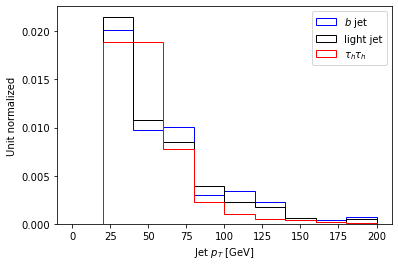

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(arrays['jet_pt'][arrays['bjet']],bins=10,range=(0,200),color='b',histtype='step',density=True)
plt.hist(arrays['jet_pt'][arrays['lightjet']],bins=10,range=(0,200),color='k',histtype='step',density=True)
plt.hist(arrays['jet_pt'][arrays['TauHTauH']],bins=10,range=(0,200),color='r',histtype='step',density=True)
plt.legend(['$b$ jet','light jet',r'$\tau_{h}\tau_{h}$'])
plt.xlabel('Jet $p_{T}$ [GeV]')
plt.ylabel('Unit normalized')
plt.show()

In [7]:
weight_bins = [
    # jet_pt
    np.array(
        [20,25,30,35,40,50,60,80,100,200,500,1000,2000,7000],
        dtype=float
    ),
    # jet_abseta
    np.array(
        [0.0,0.5,1.0,1.5,2.0,2.5],
        dtype=float
    ),
]

weight_branches = ['jet_pt','jet_eta']
weight_bin_labels = ['jet_pt','jet_abseta']
weight_bin_axis_labels = [r'Jet $p_{T}$', r'Jet $|\eta|$']
reference = 'TauHTauH'

def weight_fname(fnames):
    distributions = {}
    for arrays in uproot.iterate(fnames,treename,truth_branches+weight_branches,namedecode="utf-8",entrysteps=100000):
        arrays['jet_abseta'] = abs(arrays['jet_eta'])
        arrays, keep = build_truth(arrays,fname)
    
        for truth in out_truth:
            hist, xedges, yedges = np.histogram2d(
                arrays[weight_bin_labels[0]][arrays[truth]],
                arrays[weight_bin_labels[1]][arrays[truth]],
                weight_bins
            )
            if truth in distributions:
                distributions[truth] = distributions[truth]+hist
            else:
                distributions[truth] = hist
    return distributions, xedges, yedges

def divide_distributions(a,b):
    out = np.array(a)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            out[i][j] = a[i][j]/b[i][j] if b[i][j] else 1
    return out

In [8]:
distributions, xedges, yedges = weight_fname(fnames)
for truth in out_truth:
    distributions[truth] = distributions[truth]/distributions[truth].sum()

A simple approach is to define a reference class (here our signal class) and then determine the weight for a given $p_{T}$/$|\eta|$ bin for the other classes to match the target distribution.

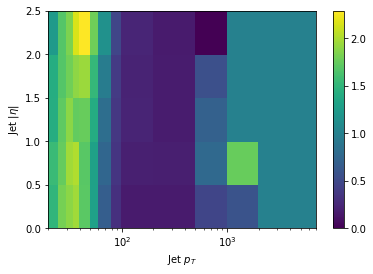

In [55]:
weight_distributions = {}
for truth in out_truth:
    weight_distributions[truth] = divide_distributions(distributions[reference],distributions[truth])
    

H = weight_distributions['bjet'].T
fig = plt.figure()
ax = fig.add_subplot(111)
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, H)
fig.colorbar(im, ax=ax)
ax.set_xscale("log", nonposx='clip')
plt.xlabel(weight_bin_axis_labels[0])
plt.ylabel(weight_bin_axis_labels[1])
plt.show()

### Feature normalization

An important part of developing a network is normalizing the input features. Networks learn best when the individual features all have similar values. A common approach is to perform a preprocessing step where the means and standard deviations of each feature are determined from a representative sample and then each feature is normalized to 0 with a deviation of 1.

Alternatively (and what we will do with features like the jet $|\eta|$), you can linear normalize the feature from 0 to 1 (-1 to 1). Or, as a modification, for features that are not linearly distributed but follow an exponential profile (like jet $p_{T}$), log-linearize.

In [10]:
# can optionally linearize branches between [0,1]
linear_branches = {
    'jet_eta': [-2.5,2.5],
    'jet_phi': [-np.pi,np.pi],
}
# or for momentum, log-linearize
loglinear_branches = {
    'jet_pt': [20.,7000.],
}

# the remainding branches will be unit normalized

Before we start getting the means of our input features, we need to perform all transformations on the input features that we desire.
This step will then be repeated before producing our training dataset (as well as before evaluating the network when we are done).
This allows us to use some intuition and physics knowledge to reduce some degrees of freedom to the network, allowing the network to learn faster.

The first set of modifications are renormalizing the jet PF constituents to be relative to the jet axis.
 - $p_{T}^{rel} = p_{T}^{d} / p_{T}^{jet}$
 - $\eta^{rel} = \eta^{d} - \eta^{jet}$
 - $\phi^{rel} = \phi^{d} - \phi^{jet}$

The second set of modifications splits the daughters based on their PF type: charged hadron, neutral hadron, muon, electron, photon.

At this point you could consider other modifications.
A common approach for imaged-based jet tagging is to rotate and flip the daughters, while maintaining lorentz invaraniance, to minimize differences between jets.
We won't use images here. Instead we will create vectors of features that are fed into a recurrent network.
In our case, we should probably sort them into a logical order.
Currently this is just the order in MiniAOD.
In theory it is $p_{T}$ ordered, but this is not guaranteed, especially after RERECO and modifications to the jet energy that may occur during calibration.

Another approach that we can try is a point cloud, where order doesn't matter at all.
We will discuss this later.

In [11]:
def transform(arrays):
    for key in branches:
        if key not in arrays: continue
        # adapt daughters to remove some degrees of freedom
        if key=='jet_daughter_pt':
            arrays[key] = arrays[key]/arrays['jet_pt']
        if key=='jet_daughter_eta':
            arrays[key] = arrays[key]-arrays['jet_eta']
        if key=='jet_daughter_phi':
            arrays[key] = arrays[key]-arrays['jet_phi']

        # create reduced arrays of daughters
        if 'jet_daughter_' not in key: continue
        chkey = key.replace('jet_daughter_','charged_hadron_')
        nhkey = key.replace('jet_daughter_','neutral_hadron_')
        mkey = key.replace('jet_daughter_','muon_')
        ekey = key.replace('jet_daughter_','electron_')
        pkey = key.replace('jet_daughter_','photon_')
        chmask = ((abs(arrays['jet_daughter_pdgId'])!=13)
                & (abs(arrays['jet_daughter_pdgId'])!=11) 
                & (abs(arrays['jet_daughter_pdgId'])!=22) 
                & (abs(arrays['jet_daughter_charge'])>0))
        nhmask = ((abs(arrays['jet_daughter_pdgId'])!=13)
                & (abs(arrays['jet_daughter_pdgId'])!=11) 
                & (abs(arrays['jet_daughter_pdgId'])!=22) 
                & (abs(arrays['jet_daughter_charge'])==0))
        mmask = (abs(arrays['jet_daughter_pdgId'])==13)
        emask = (abs(arrays['jet_daughter_pdgId'])==11)
        pmask = (abs(arrays['jet_daughter_pdgId'])==22)
        arrays[chkey] = arrays[key][chmask]
        arrays[nhkey] = arrays[key][nhmask]
        arrays[mkey] = arrays[key][mmask]
        arrays[ekey] = arrays[key][emask]
        arrays[pkey] = arrays[key][pmask]
    return arrays

When doing the full training, we processing 10% of the samples to get a representative distribution of each feature.
Here I will process only one file. Additionally, I will only use a subset of branches to speed things along.

In [12]:
branches = [
    'jet_pt','jet_eta','jet_phi','jet_mass',
    'jet_daughter_pt', 'jet_daughter_eta', 'jet_daughter_phi','jet_daughter_charge',
]
other_branches = [
    'jet_hadronFlavour',
    'jet_partonFlavour',
    'jet_daughter_pdgId',
]
charged_hadron_branches = [b.replace('jet_daughter','charged_hadron') for b in branches if b.startswith('jet_daughter')]
neutral_hadron_branches = [b.replace('jet_daughter','neutral_hadron') for b in branches if b.startswith('jet_daughter')]
muon_branches = [b.replace('jet_daughter','muon') for b in branches if b.startswith('jet_daughter')]
electron_branches = [b.replace('jet_daughter','electron') for b in branches if b.startswith('jet_daughter')]
photon_branches = [b.replace('jet_daughter','photon') for b in branches if b.startswith('jet_daughter')]
branch_groupings = [
    [b for b in branches if not 'jet_daughter_' in b],
    charged_hadron_branches,
    neutral_hadron_branches,
    muon_branches,
    electron_branches,
    photon_branches,
]
all_branches = []
for bg in branch_groupings:
    all_branches += bg

In [13]:
def mean_fname(fname,i):
    means = {key:[] for key in all_branches}
    varis = {key:[] for key in all_branches}
    for arrays in uproot.iterate(fname,treename,branches+truth_branches+other_branches,namedecode="utf-8",entrysteps=100000):
        for key in arrays:
            # convert vector<vector<T>> (ObjectArray by default) into nested JaggedArray
            if isinstance(arrays[key],awkward.ObjectArray): arrays[key] = awkward.fromiter(arrays[key])
        arrays, keep = build_truth(arrays,fname)
        for key in arrays:
            arrays[key] = arrays[key][keep]

        arrays = transform(arrays)
        for key in arrays:
            if key not in all_branches: continue
            # skip jet_daughter since it was renamed
            if 'jet_daughter_' in key: continue
            a = arrays[key]
            while isinstance(a,awkward.JaggedArray): a = a.flatten()
            if a.size==0: continue
            # remove NaNs, but should understand why they happen
            a = a[~np.isnan(a)]
            a = a[~np.isinf(a)]
            m = a.mean()
            v = a.var()
            if np.isnan(m):
                logging.error(f'NaN found: {key}')
                print(fname)
                raise ValueError
            elif np.isinf(m):
                logging.error(f'Inf found: {key}')
                print(fname)
                raise ValueError
            else:
                # protection against empty arrays
                means[key] += [m]
                varis[key] += [v]
    return {'means': means, 'varis': varis}

In [14]:
result = mean_fname(fnames[0],0)

Let's look at the values of the means. This is what we will modify our distributions by later. Importantly, this may not make sense for all variables. For things like the jet $p_{T}$ we will do log-linear instead.

In [15]:
means = {key: np.array(result['means'][key]).mean() for key in all_branches}
varis = {key: np.array(result['varis'][key]).mean() for key in all_branches}
stds  = {key: np.sqrt(np.array(result['varis'][key]).mean()) for key in all_branches}
# protection against divide by 0 later
stds  = {key: std if std else 1.0 for key,std in stds.items()}
for key in all_branches:
    print(f'{key}: {means[key]} +/- {stds[key]}')

jet_pt: 76.24352264404297 +/- 52.59635925292969
jet_eta: 0.001153501565568149 +/- 1.167517066001892
jet_phi: 0.0016875877045094967 +/- 1.8125505447387695
jet_mass: 11.529624938964844 +/- 6.985304355621338
charged_hadron_pt: 0.044893596321344376 +/- 0.06369731575250626
charged_hadron_eta: -0.0008813664899207652 +/- 0.16539567708969116
charged_hadron_phi: -0.0030924512539058924 +/- 0.8379696607589722
charged_hadron_charge: 0.03305397555232048 +/- 0.9994529485702515
neutral_hadron_pt: 0.05273522809147835 +/- 0.06657958030700684
neutral_hadron_eta: -0.0003842728037852794 +/- 0.17847874760627747
neutral_hadron_phi: -0.005058301147073507 +/- 0.9283478856086731
neutral_hadron_charge: 0.0 +/- 1.0
muon_pt: 0.18077482283115387 +/- 0.1699002981185913
muon_eta: 0.0015767131699249148 +/- 0.10934749245643616
muon_phi: 0.0007524790125899017 +/- 0.6580774188041687
muon_charge: -0.013374929316341877 +/- 0.9998905062675476
electron_pt: 0.23122544586658478 +/- 0.17744767665863037
electron_eta: -0.0002575

### Sample conversion

Putting the above together, we now need to convert our input arrays into the output numpy structures that we will feed to our network.
The structure for a majority of network trainings are two (or three) arrays:
 - $X$: the input features
 - $Y$: the output to predict (we tell it the truth, when we evaluate the network gives us the prediction)
 - $W$: an optional weight to apply on a given sample. This is used in case we have unbalanced classes/features (which we do).
 
 Each of these arrays can actually be more than one numpy array. In our case we will have 6 input arrays, the first corresponding to the jet features and the remaining 5 to the daughter pf candidate features. You can also have multiple outputs. Imagine the case you want to predict dog or cat, but also if it is black or white. You could have 4 classes, or two sets of two classes. We will have one output, the jet category. Finally, the weights are optional. Our weights will be based on the jet $p_{T}$/$|\eta|$ distributions we calculated before.

In [16]:
# this function calculates the weight that we will apply for a given jet
def weighting(arrays):
    # create abseta
    arrays['jet_abseta'] = abs(arrays['jet_eta'])
    arrays['weight'] = np.zeros(arrays['jet_abseta'].shape)
    for truth in out_truth:
        for xi in range(len(xedges)-1):
            for yi in range(len(yedges)-1):
                mask = ((arrays[truth]) 
                    & (arrays[weight_bin_labels[0]]>xedges[xi]) 
                    & (arrays[weight_bin_labels[0]]<xedges[xi+1])
                    & (arrays[weight_bin_labels[1]]>yedges[yi]) 
                    & (arrays[weight_bin_labels[1]]<yedges[yi+1]))
                arrays['weight'][mask] = weight_distributions[truth][xi][yi]
    return arrays

In [17]:
# this fuction normalizes each feature using the linear, log-linear, or (default) unit normal weighting from above
def normalize(arrays):
    for key in all_branches:
        if key in linear_branches:
            arrays[key] = (arrays[key].clip(*linear_branches[key])-linear_branches[key][0])/(linear_branches[key][1]-linear_branches[key][0])
        elif key in loglinear_branches:
            arrays[key] = (np.log(arrays[key].clip(*loglinear_branches[key]))-np.log(loglinear_branches[key][0]))/(np.log(loglinear_branches[key][1])-np.log(loglinear_branches[key][0]))
        else:
            arrays[key] = arrays[key]-means[key]
            arrays[key] = arrays[key]/stds[key]
    return arrays

I mentioned before that we will be using a recurrent network in this example. In our case, we will always feed the same length of vectors into the network. This means we need to truncate jets with more than the maximum number of PF candidates, and zero pad those with less than that number.
An alternative approach is to use a point cloud. This is something that I still need to develop.

In [18]:
# how much to zero pad and truncate branches
branch_lengths = {}
branch_lengths.update({b:10 for b in charged_hadron_branches})
branch_lengths.update({b:10 for b in neutral_hadron_branches})
branch_lengths.update({b:4 for b in muon_branches})
branch_lengths.update({b:4 for b in electron_branches})
branch_lengths.update({b:4 for b in photon_branches})

# this function pads and truncates the arrays that can be jagged (like pf candidates)
def padtruncate(arrays):
    for b,l in branch_lengths.items():
        if b not in arrays: continue
        arrays[b] = arrays[b].pad(l,clip=True).fillna(0.0).regular()
    return arrays

And finally, we get to the actual conversion step. In the real process, we will save these all to a numpy array file. However, here we will load them into memory and immediately start training.

In [19]:
decorrelate = False # don't decorrelate for now
def get_data():
    outX = {}
    outY = {}
    outW = {}
    for arrays in uproot.iterate(fnames,treename,truth_branches+other_branches+branches,namedecode="utf-8",entrysteps=100000):

        # convert vector<vector<T>> (ObjectArray by default) into nested JaggedArray
        for key in other_branches+branches:
            if isinstance(arrays[key],awkward.ObjectArray): arrays[key] = awkward.fromiter(arrays[key])

        # define truth
        arrays, keep = build_truth(arrays,fname)

        # selections
        for key in arrays:
            arrays[key] = arrays[key][keep]

        # calculate weight
        arrays = weighting(arrays)

        # transform
        arrays = transform(arrays)

        # normalize
        arrays = normalize(arrays)

        # zero pad and truncate
        arrays = padtruncate(arrays)
    

        # zero out NaN/Inf
        # we've alread padtruncate into numpy ndarray, so only do the ones we will save
        # and dont worry about jagged arrays
        for key in arrays:
            if key not in all_branches: continue
            a = arrays[key]
            notgood = (np.isnan(a) | np.isinf(a))
            while not isinstance(notgood,np.bool_):
                notgood = notgood.any()
            if notgood:
                a[np.isnan(a)] = 0
                a[np.isinf(a)] = 0
                arrays[key] = a
                

        def get_output(arrays,out_truth,selection=None):
            if selection is None:
                selection = np.ones_like(arrays['weight'], dtype=bool)
            W = arrays['weight'][selection]
            W = np.reshape(W,(W.shape[0],1))
            # note: this stacks the list of arrays that happens if a branch is an array
            X = [np.swapaxes(np.stack([arrays[ab][selection] for ab in groupb]),0,1) for groupb in branch_groupings]
            if decorrelate:
                Y = [np.swapaxes(np.stack([arrays[ot][selection] for ot in out_truth]),0,1),
                     np.swapaxes(np.stack([arrays[ov][selection] for ov in out_vars]),0,1)]
            else:
                Y = [np.swapaxes(np.stack([arrays[ot][selection] for ot in out_truth]),0,1)]
            return W, X, Y
    
        W, X, Y = {}, {}, {}
        for truth in out_truth:
            W[truth], X[truth], Y[truth] = get_output(arrays,out_truth,arrays[truth])
            if truth in outW:
                outX[truth] = [np.vstack([outX[truth][i],X[truth][i]]) for i in range(nx)]
                outY[truth] = [np.vstack([outY[truth][i],Y[truth][i]]) for i in range(ny)]
                outW[truth] = np.vstack([outW[truth],W[truth]])
            else:
                outX[truth] = X[truth]
                outY[truth] = Y[truth]
                outW[truth] = W[truth]
                
    return outX, outY, outW



In [20]:
nx = 6
ny = 1

X, Y, W = get_data()

# balance the classes
class_counts = [Y[truth][0].shape[0] for truth in out_truth]
min_c = min(class_counts)

X = {truth: [X[truth][i][:min_c] for i in range(nx)] for truth in out_truth}
Y = {truth: [Y[truth][i][:min_c] for i in range(ny)] for truth in out_truth}
W = {truth: W[truth][:min_c] for truth in out_truth}

X = [np.vstack([X[truth][i] for truth in out_truth]) for i in range(nx)]
Y = [np.vstack([Y[truth][i] for truth in out_truth]) for i in range(ny)]
W = np.vstack([W[truth] for truth in out_truth])
W = np.reshape(W,(W.shape[0],))

We now have our data with equal category representation and jet $p_{T}$/$|\eta|$ distributions via weighting.

In [21]:
print([xi.shape for xi in X])
print([yi.shape for yi in Y])
print(W.shape)

[(179220, 4), (179220, 4, 10), (179220, 4, 10), (179220, 4, 4), (179220, 4, 4), (179220, 4, 4)]
[(179220, 3)]
(179220,)


At this point, you would want to set aside some data for evaluation peformance. In the main script 10% is set aside. A small change that should be made is to set aside one of the mass points of the signal to evaluate performance on a mass hypothesis that has not yet been checked.

## Training

Let's move on to building the model and training over the data we just produced.
This model will be built with 6 inputs. The first input is the global jet features. The remaining 5 are the PF candidate features.
Each PF candidate input will pass through a recurrent layer (long short-term memory, LSTM). These will then be concatenated with the global jet features and pass through a dense network until finally reaching the final output layer which has three nodes, one for each category.
Between each layer is a dropout layer which prevents over fitting. Before each layer is a batch normalization layer, which does the work of normalizing the inputs to each layer back to 0 with sigma of 1.

In [22]:
# this is for tensorflow 2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Concatenate, LSTM, Convolution1D, Masking, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, History, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

def build_model(input_shapes, num_classes, 
                batchnorm=True, momentum=0.6, 
                dropoutRate=0.2, lr=0.0001, 
                width = 128, depth=4,
                pattern=[], kernel=[],
                doLSTM=True,lstmWidth=128):
    if len(kernel) != len(pattern): kernel = [1]*len(pattern)

    inputs = [Input(shape=s) for s in input_shapes]

    concat = [inputs[0]]

    for i in range(1,len(input_shapes)):
        x = inputs[i]
        for j,p in enumerate(pattern):
            x  = Convolution1D(p, kernel[j], kernel_initializer='lecun_uniform',  activation='relu', name='conv_{}_{}'.format(i,j))(x)
            if j<len(pattern)-1:
                if batchnorm:
                    x = BatchNormalization(momentum=momentum ,name='conv_batchnorm_{}_{}'.format(i,j))(x)
                x = Dropout(dropoutRate,name='conv_dropout_{}_{}'.format(i,j))(x)

        # LSTM
        if doLSTM:
            # Not supported with plaidML
            #if not usePlaid:
            #    x = Masking(mask_value=0., name='masking_{}'.format(i))(x)
            x = LSTM(lstmWidth,implementation=2, name='lstm_{}'.format(i))(x)
            if batchnorm:
                x = BatchNormalization(momentum=momentum,name='lstm_batchnorm_{}'.format(i))(x)
            x = Dropout(dropoutRate,name='lstm_dropout_{}'.format(i))(x)
        # flatten
        else:
            x = Flatten()(x)
        concat += [x]



    if len(concat)>1:
        layer = Concatenate()(concat)
    else:
        layer = concat[0]

    for i in range(depth):
        layer = Dense(width, activation='relu', kernel_initializer='lecun_uniform', name='dense_{}'.format(i))(layer)
        if batchnorm:
            layer = BatchNormalization(momentum=momentum, name='dense_batchnorm_{}'.format(i))(layer)
        layer = Dropout(dropoutRate, name='dense_dropout_{}'.format(i))(layer)

    prediction = Dense(num_classes, activation='softmax', kernel_initializer='lecun_uniform', name='ID_pred')(layer)

    outputs = [prediction]

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(lr=lr)
    loss = ['categorical_crossentropy']
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'],
    )
    return model


Build the model. We will print out a summary of the layers below. It shows all the layers as well as the number of trainable parameters. In general, more parameters means more learning capacity. In theory, if you have enough densely connected nodes, a single hidden layer will have the same performance as doing something more complicated. However, our graphics cards are limited in size and our lives are limited in time.

In [23]:
modelArgs = {
    'doLSTM': True,
    'lstmWidth': 128,
    'depth': 4,
    'width': 128,
    'batchnorm': True,
    'momentum': 0.6, # 0.6-0.85 for large batches (5k+), larger (0.9-0.99) for smaller batches
    'dropoutRate': 0.2,
    'lr': 1e-3,
}
model = build_model([X[i].shape[1:] for i in range(nx)],len(out_truth),**modelArgs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4, 4)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 4, 4)]       0                                            
______________________________________________________________________________________________

And now we train. We will save the history of the training for plotting later. During the actual training, there will additionally be callbacks that are run during the training to do handy things as it progresses, such as periodically save the model.

In [24]:

history = model.fit(X, Y,
                    batch_size = 2000,
                    epochs = 10, 
                    verbose = 1,
                    validation_split = 0.1,
                    shuffle = True,
                    sample_weight = W,
                    )

Train on 161298 samples, validate on 17922 samples
Epoch 1/10
161298/161298 [==============================] - 68s 422us/sample - loss: 1.1100 - accuracy: 0.4315 - val_loss: 1.0524 - val_accuracy: 0.5061
Epoch 2/10
161298/161298 [==============================] - 52s 321us/sample - loss: 0.9900 - accuracy: 0.5036 - val_loss: 1.0317 - val_accuracy: 0.5353
Epoch 3/10
161298/161298 [==============================] - 51s 315us/sample - loss: 0.9570 - accuracy: 0.5269 - val_loss: 0.9891 - val_accuracy: 0.5768
Epoch 4/10
161298/161298 [==============================] - 54s 337us/sample - loss: 0.9386 - accuracy: 0.5411 - val_loss: 1.0131 - val_accuracy: 0.5601
Epoch 5/10
161298/161298 [==============================] - 55s 344us/sample - loss: 0.9266 - accuracy: 0.5478 - val_loss: 0.9754 - val_accuracy: 0.5773
Epoch 6/10
161298/161298 [==============================] - 56s 349us/sample - loss: 0.9180 - accuracy: 0.5532 - val_loss: 0.9589 - val_accuracy: 0.6191
Epoch 7/10
161298/161298 [=====

Let's look at the loss and accuracy as a function of epoch.

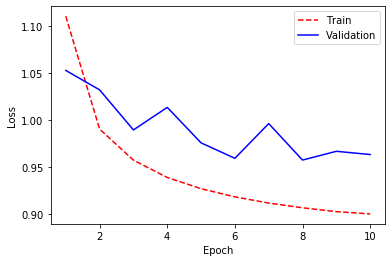

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_count = range(1, len(loss) + 1)

plt.figure()
plt.plot(epoch_count, loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

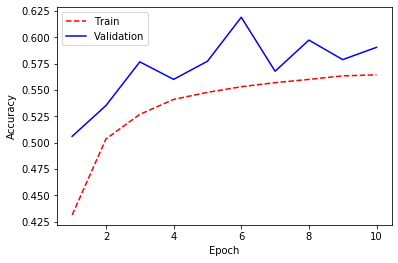

In [26]:
plt.figure()
plt.plot(epoch_count, acc, 'r--')
plt.plot(epoch_count, val_acc, 'b-')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Of course, running over the full data with more epochs results in a much better network. With the ~4 million samples in the full dataset you can expect a loss of ~0.4 and accuracy ~0.83 with this network.